In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Activation, Input #changed 'keras.' to 'tensorflow.keras.'
from tensorflow.keras.models import Sequential, Model #changed 'keras.' to 'tensorflow.keras.'
from tensorflow.keras import optimizers #changed 'keras.' to 'tensorflow.keras.'
import cv2
import math
import glob
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from IPython.display import display
from keras_vggface.vggface import VGGFace
import sys
from keras.models import load_model
import mtcnn
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
import keras
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from keras.models import load_model
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
target_shape = (160, 160)

In [2]:
model = VGGFace()
model.summary()
#weight = model.get_weights()
#print(weight)

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

In [3]:
temp = Sequential()
for layer in model.layers[0:-4]: # just exclude last two layers from copying
    temp.add(layer)

for layer in temp.layers[0:9]:
    layer.trainable = False
#temp.summary()

In [ ]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

directory = "finaltrain"
train_ds = image_dataset_from_directory(
    directory, label_mode=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True, seed=0, validation_split=None, subset=None,
    interpolation='bicubic', follow_links=False)
directory = "newval"
valid_ds = image_dataset_from_directory(
    directory, label_mode=None, color_mode='rgb', batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True, seed=0, validation_split=None, subset=None,
    interpolation='bicubic', follow_links=False)

In [4]:
input_img = Input(shape=(160,160,3))
C1 = Conv2D(96,(9,9),padding='SAME',name='CONV1')(input_img)
A1 = Activation('relu', name='act1')(C1)
C2 = Conv2D(64,(1,1),padding='SAME',name='CONV2')(A1)
A2 = Activation('relu', name='act2')(C2)
C3 = Conv2D(48,(1,1),padding='SAME',name='CONV3')(A2)
A3 = Activation('relu', name='act3')(C3)
C4 = Conv2D(32,(1,1),padding='SAME',name='CONV4')(A3)
A4 = Activation('relu', name='act4')(C4)
C5 = Conv2D(3,(5,5),padding='SAME',name='CONV5')(A4)
A5 = Activation('relu', name='act5')(C5)
SR = Model(input_img, A5)
opt = optimizers.Adam(learning_rate = 0.00001)
SR.compile(optimizer=opt,loss='mean_squared_error',metrics=['accuracy'])

In [ ]:
#SR = keras.models.load_model('Models/SR/SRnet')
#SR.load_weights('Models/SR/epoch101-110/SRnetweights.h5')

In [5]:
'''callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=7,
                              verbose=0, mode='min', restore_best_weights=False)'''

input_img = Input(shape=(224,224,3))
A5 = SR(input_img) 
A6 = temp(A5)
SRFECNN = Model(input_img, A6)
opt = optimizers.Adam(learning_rate = 0.0000008)
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    
SRFECNN.compile(
    optimizer=opt,
    loss=root_mean_squared_error,
    metrics=['accuracy'])
for layer in SRFECNN.layers[0:-1]:
    layer.trainable = False
#SRFECNN.load_weights('Models/twobranch/twobranch_weights_e1_rms.h5')
#SRFECNN.compile(optimizer=opt,loss='root_mean_squared_error',metrics=['accuracy'])
SRFECNN.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model (Functional)           (None, 160, 160, 3)       36723     
_________________________________________________________________
sequential (Sequential)      (None, 4096)              117479232 
Total params: 117,515,955
Trainable params: 115,743,744
Non-trainable params: 1,772,211
_________________________________________________________________


In [ ]:
FECNN = Sequential()
for layer in model.layers[0:-2]: # just exclude last two layers from copying
    FECNN.add(layer)
for layer in FECNN.layers:
    layer.trainable = False

#weights = FECNN.get_weights()
#print(weights)
#FECNN.save('Models/FECNN')
FECNN.summary()


In [ ]:
# to generate training images, we first need to downscale the image by scaler factor and then upscale it back to the original size
def create_LR(image): 
    image = image / 255 #normalising the pixel values
    image = tf.image.resize(image, [24, 24], method="bicubic") #for 36x35, batches~75, loss~4000, accuracy~62
    image = tf.image.resize(image, [224, 224], method="bicubic")
    return image

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(
    lambda x: (create_LR(x), FECNN(x))
)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

#valid_ds = valid_ds.map(
#    lambda x: (create_LR(x), FECNN(x))
#)
#valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
SRFECNN.load_weights('Models/twobranch_overfit/final2.h5')

In [ ]:
import time
start = time.time()
history = SRFECNN.fit(train_ds, epochs=20)
end = time.time()
print(end - start)

In [ ]:
#SRFECNN.save('Models/SRFECNN')
#SRFECNN.save('Models/twobranch/twobranch_weights_e1.h5')

In [ ]:
SRFECNN.save('Models/twobranch_overfit/final2.h5')

In [ ]:
dic = dict()
i=0
TP = 0

for filename in os.listdir('finaltrain/finaltrain'):
    img = cv2.imread(os.path.join('finaltrain/finaltrain',filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgr = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
    imgr = np.array([imgr])
    imgr = tf.convert_to_tensor(imgr)
    vec = FECNN.predict(imgr)
    vec = vec.flatten()
    dic['s'+ str(i)] = vec
    i = i+1
#print(dic)

In [ ]:
import time
start = time.time()
i=0
FP=0
TN=0
FN=0
accuracy = 0
t=7.5
b=0
b = []
for filename in os.listdir('finaltest/test'):
    img = cv2.imread(os.path.join('finaltest/test',filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (24,24), interpolation=cv2.INTER_CUBIC)
    img1 = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
    imgr = np.array([img1])
    imgr = tf.convert_to_tensor(imgr)
    vec1 = SRFECNN.predict(imgr)
    vec1 = vec1.flatten()
    #print(vec1)
    vec1 = vec1/np.linalg.norm(vec1)
    a=[]
    for j in range(100):
        k = 's' + str(j)
        vec2 = dic[k]/np.linalg.norm(dic[k])
        dist = np.linalg.norm(vec2-vec1)
        dist = dist.flatten()
        a.append(dist)
    b.append(min(a))
'''if(dist.numpy()<=5 and j==int(i/5)):
            TP = TP + 1
            accuracy = accuracy + 1
        elif(dist.numpy()<=5 and j!=int(i/5)): 
            FP = FP + 1
        
        #print("dist = ",dist,"subject = ",j,"i = ",i)
    temp = max(a)
    #print(temp)
    if(temp.numpy()<t):
        if(i<50):
            b-=1
        accuracy+=1
    i = i+1
print(accuracy)
print(b)

P = TP/(TP+FP)
R = TP/(TP+FN)
F1 = 2*P*R/(P+R)
print(P) 0.76
print((accuracy/500)*100)
end = time.time()
print(end - start)'''
#print(a)

In [ ]:
print(b)

In [ ]:
import sklearn
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=2)
labels = kmean.fit_predict(b)
print(labels)


In [ ]:
labels_1=[]
labels_0=[]

for i in range(len(labels)):
    if(labels[i]==1):
        labels_1.append(b[i])
    else:
        labels_0.append(b[i])

In [ ]:
print(labels_1)
print(labels_0)

In [ ]:
kmean.cluster_centers_

In [ ]:
#plt.ylim(0,1)
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Image number', fontsize = 15)
ax.set_ylabel('Distance', fontsize = 15)
ax.set_title('KMeans clustering', fontsize = 20)
ax.scatter(range(0,40),labels_0,color='red')
ax.scatter(range(40,66),labels_1,color='blue')
ax.scatter([20,53],[[0.37287224],
       [0.11982424]],marker='x',linewidths=3,color='purple')
ax.plot([0,66],[0.235,0.235],color='green')
ax.legend(['Threshold','Img not in DB','Img in DB','Cluster centroids'])
plt.show()

In [ ]:
c = b[:40]
mini = min(c)
#print(mini)
d = b[40:]
maxi = max(d)
#print(c) maximum = 0.23314758
print(d) #minimum = 0.23771875,0.25001103

In [ ]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
start = time.time()
i=0
FP=0
TN=0
FN=0
accuracy = 0
t=7.5
b=0
x = []

'''img = cv2.imread(os.path.join('finaltrain/train',filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgr = np.array([img])
    imgr = tf.convert_to_tensor(imgr)
    vec = FECNN.predict(imgr)'''
    
for filename in os.listdir('finaltrain/finaltrain'):
    img = cv2.imread(os.path.join('finaltrain/finaltrain',filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
    imgr = np.array([img])
    imgr = tf.convert_to_tensor(imgr)
    vec = SRFECNN.predict(imgr)
    
    #print(vec)
    x.append(vec.flatten())
    #vec1 = vec1/np.linalg.norm(vec1)
    #a = []
    '''for j in range(50):
        k = 's' + str(j)
        vec2 = dic[k]/np.linalg.norm(dic[k])
        dist = tf.reduce_sum(K.sqrt(K.square(vec2-vec1)))
        a.append(dist)'''  
#print(x)
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
k=[0,2,6,8,9]
for i in range(10):
    ax.scatter(principalDf.loc[range((i*10),((i*10)+10)), 'principal component 1']
               , principalDf.loc[range((i*10),((i*10)+10)), 'principal component 2']
               , c = colors[i]
               , s = 50)
#ax.legend(targets)
ax.grid()

In [6]:
model1 = keras.models.load_model('keras-facenet-master/keras-facenet-master/model/keras/model/facenet_keras.h5')
model1.load_weights('weights.h5')
#for layer in model1.layers:
#    layer.trainable = False
model1.summary()

C:\Users\arsal\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\keras\layers\core.py:1059: UserWarning: inception_resnet_v1 is not loaded, but a Lambda layer uses it. It may cause errors.
  warnings.warn('{} is not loaded, but a Lambda layer uses it. '


Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [ ]:
model = VGGFace()
embedding = Sequential()
for layer in model.layers[0:-2]: # just exclude last two layers from copying
    embedding.add(layer)
embedding.load_weights('weights.h5')

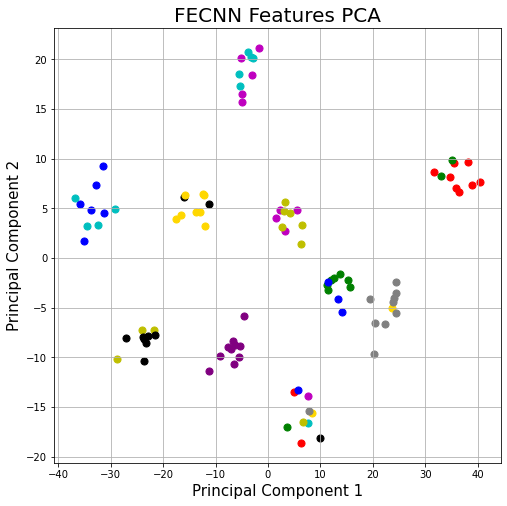

In [7]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
start = time.time()
i=0
FP=0
TN=0
FN=0
accuracy = 0
t=7.5
b=0
x = []

'''img = cv2.imread(os.path.join('finaltrain/train',filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgr = np.array([img])
    imgr = tf.convert_to_tensor(imgr)
    vec = FECNN.predict(imgr)'''
    
detector = MTCNN()

for filename in os.listdir('SRtrain/train'):
    pixels = cv2.imread(os.path.join('SRtrain/train',filename))
    pixels = cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)
    #results = detector.detect_faces(pixels)
    #x1, y1, width, height = results[0]['box']
    #x1, y1 = abs(x1), abs(y1)
    #x2, y2 = x1 + width, y1 + height
    #img = pixels[y1:y2, x1:x2]
    #img = cv2.resize(img, (160,160), interpolation=cv2.INTER_CUBIC)
    img = pixels.astype('float32')
    mean, std = img.mean(), img.std()
    img = (img - mean) / std
    imgr = np.array([img])
    imgr = tf.convert_to_tensor(imgr)
    vec = model1.predict(imgr)
    #vec = vec/np.linalg.norm(vec)
    #print(vec)
    x.append(vec.flatten())
    #vec1 = vec1/np.linalg.norm(vec1)
    #a = []
    '''for j in range(50):
        k = 's' + str(j)
        vec2 = dic[k]/np.linalg.norm(dic[k])
        dist = tf.reduce_sum(K.sqrt(K.square(vec2-vec1)))
        a.append(dist)'''  
#print(x)
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
#plt.ylim([-30,30])
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('FECNN Features PCA', fontsize = 20)
colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
k=[0,2,6,8,9]
for i in range(10):
    ax.scatter(principalDf.loc[range((i*10),((i*10)+10)), 'principal component 1']
               , principalDf.loc[range((i*10),((i*10)+10)), 'principal component 2']
               , c = colors[i]
               , s = 50)
#ax.legend(targets)
ax.grid()

In [ ]:
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
#plt.ylim([-30,30])
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('FECNN Features PCA', fontsize = 20)
colors = ['r', 'g', 'b','c','m','y','k','gold','grey','purple']
k=[0,2,6,8,9]
for i in range(10):
    ax.scatter(principalDf.loc[range((i*10),((i*10)+10)), 'principal component 1']
               , principalDf.loc[range((i*10),((i*10)+10)), 'principal component 2']
               , c = colors[i]
               , s = 50)
#ax.legend(targets)
ax.grid()

In [ ]:
dic = dict()
i=0
accuracy = 0
threshold = 2.2
for filename in os.listdir('finaltrain/train'):
    img = cv2.imread(os.path.join('finaltrain/train',filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgr = np.array([img])
    imgr = tf.convert_to_tensor(imgr)
    vec = FECNN.predict(imgr)
    dic['s'+ str(i)] = vec
    i = i+1
i=0
dic1 = dict()
for filename in os.listdir('finaltest/test'):
    img = cv2.imread(os.path.join('finaltest/test',filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
    imgr = np.array([img1])
    imgr = tf.convert_to_tensor(imgr)
    vec1 = SRFECNN.predict(imgr)
    vec1 = vec1/np.linalg.norm(vec1)
    temp = 9999999
    for j in range(500):
        k = 's' + str(j)
        vec2 = dic[k]/np.linalg.norm(dic[k])
        dist = tf.reduce_sum(K.sqrt(K.square(vec2-vec1)))
        if(dist.numpy()<temp):
            temp = dist.numpy()
            dic1[i].append(j)
            dic1[i].append(temp)
    i = i+1
for test, subject, distance in dic1.items():
    if(int(test/5)==int(subject/10) and distance<threshold):
        accuracy = accuracy + 1
                    
print((accuracy/250)*100)

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Squared Error')
plt.ylim([0,100])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
img = cv2.imread('train/train/ATT_49_1988739.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#display(array_to_img(img))
#print(img)
#plt.imshow(img)
img = img/255
img1 = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
img1 = cv2.resize(img, (36,36), interpolation=cv2.INTER_CUBIC)
img1 = cv2.resize(img1, (224,224), interpolation=cv2.INTER_CUBIC)
#img1 = img1*255
plt.imshow(img1)

#cv2.imwrite('HR1.bmp', img1)
#original = cv2.imread("HR1.bmp")
#print(img.shape)

In [ ]:
imgr = np.array([img1])
imgr = tf.convert_to_tensor(imgr)
img_HR = model.predict(imgr)
#print(img_HR)
img2 = np.array(img_HR,dtype=np.uint8)
img2 = img2[0,:]
plt.imshow(img2)

In [ ]:
dic = dict()
i=0
for filename in os.listdir('finaltrain/finaltrain'):
    img = cv2.imread(os.path.join('finaltrain/finaltrain',filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
    imgr = np.array([img])
    imgr = tf.convert_to_tensor(imgr)
    vec = FECNN.predict(imgr)
    dic['s'+ str(i)] = vec
    i = i+1
i=0
Dist_pred=[]
ID_pred=dict()
io_labels_pred = [] #in  - 1, out - 0.
io_labels_orig = [0 for i in range(40)] + [1 for i in range(40,70)]
ID_orig = [-1 for i in range(40)] + [int(i/3) for i in range(30)]
names = dict(zip([0,1,2,3,4,5,6,7,8,9],['Arsalan','Tony','Peter','Steve','Bucky','Wanda','Harry','Ron','Loki','Hrishi']))
names_pred = []

io_acc = 0
ID_acc = 0
threshold = 0.235
files = []
idx = []
i=0
for filename in os.listdir('finaltest/test'):
    files.append(os.path.join('finaltest/test',filename))
    img = cv2.imread(os.path.join('finaltest/test',filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (24,24), interpolation=cv2.INTER_CUBIC)
    img1 = cv2.resize(img, (224,224), interpolation=cv2.INTER_CUBIC)
    imgr = np.array([img1])
    imgr = tf.convert_to_tensor(imgr)
    vec1 = SRFECNN.predict(imgr)
    vec1 = vec1/np.linalg.norm(vec1)
    a = []
    for j in range(100):
        k = 's' + str(j)
        vec2 = dic[k]/np.linalg.norm(dic[k])
        dist = np.linalg.norm(vec2-vec1)
        dist = dist.flatten()
        a.append(dist[0])
    Dist_pred.append(min(a))
    ID_pred[i]=int(np.argmin(a)/10)
    #print(np.argmin(a))
    i+=1

for i in Dist_pred:
    if i<=threshold:
        io_labels_pred.append(1)
    else:
        io_labels_pred.append(0)

for i in range(len(io_labels_pred)):
    if io_labels_pred[i] == io_labels_orig[i]:
        io_acc += 1
    if io_labels_pred[i]==1:
        if ID_pred[i] == ID_orig[i]:
            ID_acc += 1
            names_pred.append(names[ID_pred[i]])

    
'''print("Dist_pred: ",Dist_pred)
print("ID_pred: ",ID_pred)
print("io_labels_pred: ",io_labels_pred)
print("io_labels_orig: ",io_labels_orig)
print("ID_orig: ",ID_orig)
print("names: ",names)
print("names_pred: ",names_pred)
print("io_acc = ",io_acc,"ID_acc = ",ID_acc)'''

In [ ]:
'''callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=7,
                              verbose=0, mode='min', restore_best_weights=False)'''

input_img = Input(shape=(224,224,3))
C1 = Conv2D(96,(9,9),padding='SAME',name='CONV1')(input_img)
A1 = Activation('relu', name='act1')(C1)
C2 = Conv2D(64,(1,1),padding='SAME',name='CONV2')(A1)
A2 = Activation('relu', name='act2')(C2)
C3 = Conv2D(48,(1,1),padding='SAME',name='CONV3')(A2)
A3 = Activation('relu', name='act3')(C3)
C4 = Conv2D(32,(1,1),padding='SAME',name='CONV4')(A3)
A4 = Activation('relu', name='act4')(C4)
C5 = Conv2D(3,(5,5),padding='SAME',name='CONV5')(A4)
A5 = Activation('relu', name='act5')(C5)
S = Model(input_img, A5)


S.load_weights('Models/SR/epoch101-110/SRnetweights.h5')

In [ ]:
imgt = cv2.imread('finaltest/test/GEO_27_3031237.jpg')
imgt = cv2.cvtColor(imgt, cv2.COLOR_BGR2RGB)
imgt=imgt/255
def LR(image):
    image = cv2.resize(image, (24,24), interpolation=cv2.INTER_CUBIC)
    image = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
    return image
imgT1 = LR(imgt)
imgr1 = np.array([imgT1])
imgr1 = tf.convert_to_tensor(imgr1)
img_fecnn = FECNN.predict(imgr1)
img_fecnn = np.array(img_fecnn,dtype=np.uint8)
img_fecnn = img_fecnn[0]
img_fecnn = img_fecnn/np.linalg.norm(img_fecnn)
img_fecnn = img_fecnn.reshape((64,64))

In [ ]:
imgt1 = cv2.imread('finaltest/test/GEO_27_3031237.jpg')
imgt1 = cv2.cvtColor(imgt1, cv2.COLOR_BGR2RGB)
imghr = cv2.resize(imgt1, (224,224), interpolation=cv2.INTER_CUBIC)
imgt1=imgt1/255
def LR(image):
    image = cv2.resize(image, (24,24), interpolation=cv2.INTER_CUBIC)
    image = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
    return image
imgT1 = LR(imgt1)
imgr1 = np.array([imgT1])
imgr1 = tf.convert_to_tensor(imgr1)
img_SR1 = S.predict(imgr1)
img_vec1 = SRFECNN.predict(imgr1)
#img_fecnn = FECNN.predict(imgr1)
imgSR1 = np.array(img_SR1,dtype=np.uint8)
imgSR1 = imgSR1[0,:]
img_vec1 = np.array(img_vec1,dtype=np.uint8)
img_vec1 = img_vec1[0]
img_vec1 = img_vec1/np.linalg.norm(img_vec1)
img_vec1 = img_vec1.reshape((64,64))

fig = plt.figure(figsize = (12,12), dpi = 100)

ax = plt.subplot(1,4,1)
ax.imshow(imghr)
ax.set_title("Original Image")
plt.grid(0)

ax = plt.subplot(1,4,2)
ax.imshow(imgT1)
ax.set_title("LR Image")
plt.grid(0)

ax = plt.subplot(1,4,3)
ax.imshow(img_fecnn,cmap='Greys')
ax.set_title("FECNN Output")
plt.grid(0)

ax = plt.subplot(1,4,4)
ax.imshow(img_vec1,cmap='Greys')
ax.set_title("SRFECNN Output")
plt.grid(0)
print("True Label: Peter, Predicted Label: Peter")
print("Database True Label: 1, Predicted Label: 1")